In [160]:
# Imports
import networkx as nx
import pandas as pd
import numpy as np
import random
import wikipediaapi
import wikipedia
import time
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy import spatial
from gensim.models import Word2Vec
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import spacy
import en_core_web_md # python -m spacy download en_core_web_md

wiki_wiki = wikipediaapi.Wikipedia('en')

In [161]:
# Loading data
edge_list = pd.read_csv("small_data.tsv", sep = "\t")
edge_list.head()

,source,target,depth
0,space research,advances in space research,1
1,space research,benefits of space exploration,1
2,space research,committee on space research,1
3,space research,deep space exploration,1
4,space research,lists of space programs,1


In [162]:
# Building graph
graph = nx.from_pandas_edgelist(edge_list, "source", "target", edge_attr=True)
print("Number of nodes: ", len(graph))

Number of nodes:  2096


# Node to vector representations

Algorithms:
- Deepwalk
- Node2Vec

Nodes appearing in the same context will have similar embeddings. The context is defined as sequences of nodes built by random walks.

Why not just recommend neighboring nodes instead of bothering with embeddings ? The connectedness of the nodes in a graph does not necessarily mean that they are semantically similar. Besides embeddings allow us to do linear algebra on the representations. This is especially useful for queries with multiple keywords.

In [163]:
class Deepwalk():
    """DeepWalk algorithm"""
    
    def __init__(self, graph, walk_length=10, num_walks=5):
        """Inits a Deepwalk instance.
        
        Args:
            graph: graph to embed
            walk_length: number of steps per walk
            num_walks: number of walks per starting node
        """
        
        self.graph = graph
        self.walk_length = walk_length
        self.num_walks = num_walks
        
        self.walks = []

        for node in graph.nodes():
            for i in range(self.num_walks):
                self.walks.append(self.build_walk(node))
        
    def build_walk(self, node, repeat_nodes=True):
    
        walk = [node]
    
        for i in range(self.walk_length-1):
            neighbors = list(self.graph.neighbors(node))
            if not repeat_nodes:
                neighbors = list(set(neighbors)-set(walk))
            if len(neighbors) == 0:
                break
            next_node = random.choice(neighbors)
            walk.append(next_node)
            node = next_node

        return walk
    
    def fit(self, window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20):
        """Train Word2Vec model with skip-gram and negative sampling based on pre-computed walks"""
        return Word2Vec(self.walks, size=size, window=window, 
                        min_count=min_count, sg=sg, hs=hs, negative=negative, iter=iter)

In [164]:
deepwalk = Deepwalk(graph, walk_length=10, num_walks=5)
deepwalk_model = deepwalk.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [165]:
node2vec = Node2Vec(graph, walk_length=10, num_walks=5, quiet=True)
node2vec_model = node2vec.fit(window=5, size=100, min_count=5, sg=1, hs=0, negative=10, iter=20)

In [166]:
deepwalk_model.wv.similar_by_word('space tourism')

[('space flight participant', 0.80556321144104),
 ('space tourism society', 0.6888458132743835),
 ('astronaut training', 0.6860741376876831),
 ('micro-g environment', 0.6853494048118591),
 ('reduced-gravity aircraft', 0.6682568192481995),
 ('rocketship tours', 0.6606319546699524),
 ('seti', 0.6511574387550354),
 ('nuclear powers', 0.6392217874526978),
 ('copenhagen suborbitals', 0.6284222602844238),
 ('heinlein prize for advances in space commercialization',
  0.6191519498825073)]

In [167]:
node2vec_model.wv.similar_by_word('space tourism')

[('space flight participant', 0.8024930953979492),
 ('reduced-gravity aircraft', 0.7187999486923218),
 ('astronaut training', 0.7138291597366333),
 ('micro-g environment', 0.7046424150466919),
 ('space adventures', 0.6597773432731628),
 ('commercial astronaut', 0.6566869020462036),
 ('starchaser industries', 0.6482086777687073),
 ('potential cultural impact of extraterrestrial contact', 0.6396968364715576),
 ('home on lagrange (the l5 song)', 0.6252378225326538),
 ('seti', 0.6194019913673401)]

In [168]:
nodes_to_plot = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 
                 'moon landing','space food', 'food systems on space exploration missions', 
                 'meal, ready-to-eat','space law', 'metalaw', 'moon treaty', 
                 'legal aspects of computing','astronaut training', 'reduced-gravity aircraft', 
                 'space adaptation syndrome', 'micro-g environment']

In [169]:
def plot_projection(model, nodes, dim=2, projection_method=PCA):
    """Plot the projection of embeddings after applying a dimensionality reduction method."""
    node_vectors = model.wv[nodes]
    projection = projection_method(n_components=dim)
    projections = projection.fit_transform(node_vectors)
    
    plt.figure(figsize=(10,7))
    plt.scatter(projections[:,0], projections[:,1])
    for i, node in enumerate(nodes):
        plt.annotate(node, xy=(projections[i,0], projections[i,1]))
    plt.title("{} over first {} components".format(type(projection).__name__, dim))
    plt.show()

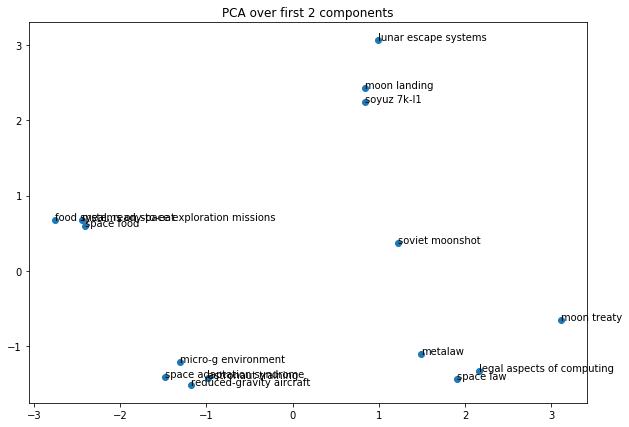

In [170]:
plot_projection(deepwalk_model, nodes_to_plot)

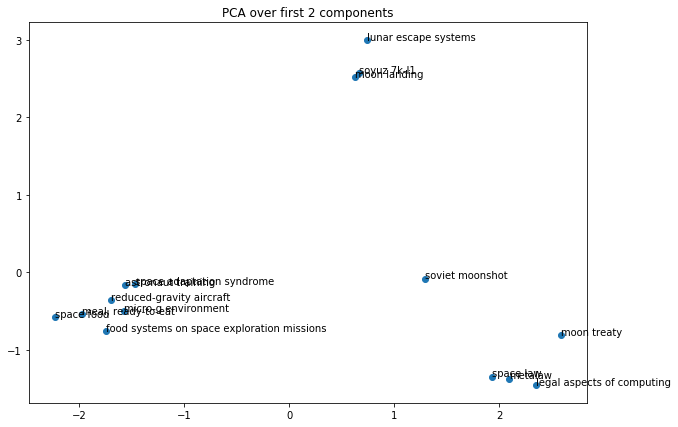

In [171]:
plot_projection(node2vec_model, nodes_to_plot)

In [172]:
def get_url(node):
    return "https://en.wikipedia.org/wiki/" + node.replace(" ", "_")

def get_url_robust(node):
    "Robust to spelling and lower case/upper case errors"
    return wikipedia.page(node).url

urls = [get_url(node) for node in graph.nodes()]

# Combining text representations and graph geometry

- Obtain representations of summaries as word2vec or bert embeddings
- Perform walks and average embeddings

## Scalability limitations

- We would need a lot of computational resources for parsing the text and learning word embeddings from all these summaries. However one can use pre-trained embeddings to fix this issue.

In [ ]:
import torch
from transformers import *

# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
nlp = en_core_web_md.load()

walks = node2vec.walks

In [61]:
def get_summary(node, num_chars=1000):
    try:
        return wiki_wiki.page(node).summary[:num_chars]
    except:
        return ''
    
def get_summary_robust(node, num_chars=1000):
    "Robust to spelling and lower case/upper case errors"
    try:
        return wikipedia.summary(node, chars=num_chars)[:num_chars] # summary may not return exactly num_chars
    except:
        return ''

In [137]:
def bert_embedding(summary):
    "Encode text using Bert model."
    input_ids = torch.tensor([tokenizer.encode(summary, add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
        last_hidden_states = last_hidden_states.squeeze().mean(dim=0)
    return last_hidden_states.numpy()

In [142]:
def get_weighted_walk_of_embeddings(walk, embeddings_dict, source_weight=0.75):
    "Given a source embedding and a walk of embeddings, returns the weighted average of embeddings."
    walk_weight = (1-source_weight)/(len(walk)-1)
    bert_embeddings = [embeddings_dict[node] for node in walk]
    return source_weight*bert_embeddings[0] + walk_weight*sum(bert_embeddings[1:])

In [101]:
def compute_similarities(summary, corpus, top_n=10):
    """Given an embedding and a corpus, returns the closest k embeddings."""
    similarities = {k:(1 - spatial.distance.cosine(summary, v))for k, v in corpus.items()}
    similarities = dict(sorted(similarities.items(), key = itemgetter(1), reverse = True)[:top_n])
    return similarities

In [151]:
# Scrapping summary for each article
# ~25 sc per 100 articles. Not very efficient since we make requests sequentially and not in batch
#t = time.time()
summaries = [get_summary(node, num_chars=280) for node in graph.nodes()]
#print("Scrapped summaries in {0:.0f} seconds".format(time.time()-t))

In [153]:
mean_embeddings = [nlp(summary).vector for summary in summaries]
embeddings_dict = dict(zip(list(graph.nodes()), mean_embeddings))

In [154]:
walk_embeddings_dict = {k:[] for k in embeddings_dict.keys()}

for walk in walks:
    walk_embeddings_dict[walk[0]].append(get_weighted_walk_of_embeddings(walk, embeddings_dict, source_weight=0.75))

walk_averaged_embeddings_dict = {k:sum(v)/len(v) for k, v in walk_embeddings_dict.items()}

In [155]:
compute_similarities(walk_averaged_embeddings_dict['data visualization'], walk_averaged_embeddings_dict)

{'data visualization': 1.0,
 'data presentation architecture': 0.9996038675308228,
 'theresa-marie rhyne': 0.9806609153747559,
 'news illustrated': 0.9777935743331909,
 '3d interaction': 0.9757876992225647,
 'sourcetrail': 0.9757266640663147,
 'ben shneiderman': 0.9754067063331604,
 'starlight information visualization system': 0.9729503393173218,
 'mevislab': 0.971404492855072,
 'widget (gui)': 0.9712947607040405}

In [156]:
mean_embeddings_bert = [bert_embedding(summary) for summary in summaries]
embeddings_dict_bert = dict(zip(list(graph.nodes()), mean_embeddings_bert))

In [157]:
walk_embeddings_dict_bert = {k:[] for k in embeddings_dict_bert.keys()}

for walk in walks:
    walk_embeddings_dict_bert[walk[0]].append(get_weighted_walk_of_embeddings(walk, embeddings_dict_bert, source_weight=0.75))

walk_averaged_embeddings_dict_bert = {k:sum(v)/len(v) for k, v in walk_embeddings_dict_bert.items()}

In [158]:
compute_similarities(walk_averaged_embeddings_dict_bert['data visualization'], walk_averaged_embeddings_dict_bert)

{'data visualization': 1.0,
 'data presentation architecture': 0.9992660284042358,
 'information visualization': 0.9307267069816589,
 'infographic': 0.9295519590377808,
 'infographics': 0.9276226162910461,
 'data acquisition': 0.9255778193473816,
 'visualization (graphic)': 0.9222146272659302,
 'application discovery and understanding': 0.9217788577079773,
 'nonlinear system identification': 0.9203293323516846,
 'knowledge visualization': 0.9198049902915955}